                 Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.832727   0.666667  0.007220  0.503246
1        Decision Tree  0.983030   0.956044  0.942238  0.966749
2              XGBoost  0.989697   0.996183  0.942238  0.970755


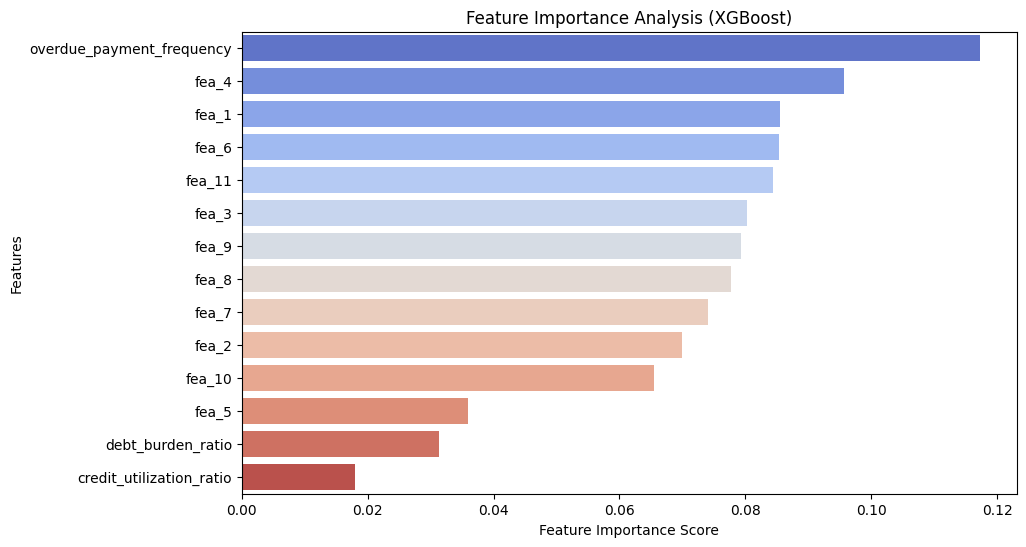

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load the datasets
# customer_data contains demographic and category features, while payment_data holds payment history
customer_data = pd.read_csv("data\customer_data.csv")
payment_data = pd.read_csv("data\payment_data.csv")


In [ ]:

# Merge both datasets on 'id' to bring together customer details and payment history
merged_data = pd.merge(customer_data, payment_data, on='id', how='left')

# Handling missing values where necessary
# - If 'fea_2' is missing, we'll replace it with its median value
# - 'prod_limit' (credit limit) is an important variable, so we'll fill missing values with its median
# - If 'highest_balance' is missing, we'll use 'new_balance' as a fallback
merged_data.loc[:, 'fea_2'] = merged_data['fea_2'].fillna(merged_data['fea_2'].median())
merged_data.loc[:, 'prod_limit'] = merged_data['prod_limit'].fillna(merged_data['prod_limit'].median())
merged_data.loc[:, 'highest_balance'] = merged_data['highest_balance'].fillna(merged_data['new_balance'])

# Feature Engineering: Creating new financial indicators
# - Credit Utilization Ratio: Measures how much credit is used compared to the limit
# - Overdue Payment Frequency: Tracks how often payments are overdue
# - Debt Burden Ratio: Measures the proportion of debt relative to income (or similar financial feature)
merged_data['credit_utilization_ratio'] = merged_data['new_balance'] / merged_data['prod_limit']
merged_data['overdue_payment_frequency'] = (merged_data['OVD_t1'] + merged_data['OVD_t2'] + merged_data['OVD_t3']) / (merged_data['pay_normal'] + 1)  # Adding 1 to avoid division by zero
merged_data['debt_burden_ratio'] = merged_data['new_balance'] / merged_data['fea_10']

# Selecting the features we want to use for training our model
features = ['credit_utilization_ratio', 'overdue_payment_frequency', 'debt_burden_ratio', 
            'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11']
X = merged_data[features]  # Independent variables
y = merged_data['label']   # Target variable (1 = high risk, 0 = low risk)



In [ ]:
# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Some models (like Logistic Regression) work better with standardized data, so we scale it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing our machine learning models
log_reg = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)  # Logistic Regression for baseline performance
decision_tree = DecisionTreeClassifier(random_state=42)  # Decision Tree for non-linear decision making
xgb = XGBClassifier(eval_metric='logloss', random_state=42)  # XGBoost for more advanced boosting-based predictions

# Training all three models
log_reg.fit(X_train_scaled, y_train)
decision_tree.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Making predictions using our trained models
log_reg_preds = log_reg.predict(X_test_scaled)
decision_tree_preds = decision_tree.predict(X_test)
xgb_preds = xgb.predict(X_test)

In [ ]:
# Function to evaluate model performance using common classification metrics
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_pred)
    }

# Collecting results from all three models
results = [
    evaluate_model(y_test, log_reg_preds, "Logistic Regression"),
    evaluate_model(y_test, decision_tree_preds, "Decision Tree"),
    evaluate_model(y_test, xgb_preds, "XGBoost")
]

# Displaying the model performance comparison
results_df = pd.DataFrame(results)
print(results_df)

# Analyzing which features were the most important in the XGBoost model
importances = xgb.feature_importances_
feature_names = X_train.columns

# Visualizing feature importance in XGBoost
sorted_indices = np.argsort(importances)[::-1]  # Sorting features by importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=np.array(feature_names)[sorted_indices], hue=np.array(feature_names)[sorted_indices], palette="coolwarm", legend=False)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.show()